In [ ]:
!pip install tweepy
!pip install nltk
!pip install twython
!pip install jsonpickle
!pip install botometer

In [14]:
import networkx as nx

In [1]:
import sys
import jsonpickle
import os
import tweepy
import nltk
import pandas as pd
import json
from pandas.io.json import json_normalize
from datetime import datetime, timezone
import numpy as np
import botometer
import re
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import time
import pickle

In [2]:
auth = tweepy.OAuthHandler('pr0AH7Ot5sZmig4u3bA6j51ty', 'tNteF0tRlEjKJfkkWQaIv5myqT9oBqrIVOYPQJOMjBTJhn9SAF')
auth.set_access_token('934846563825930241-yO5rosUB4x8eFMO0J7IXV1UZM0RzbgL', 'CbqfvlRonXo2JiIyxqCqeZynwkslNcDPmGFQ9KBEh8Mch')
api = tweepy.API(auth)

mashape_key = "uIX3UUkrh7mshux9VLXhN1FcUYY0p1ZEJpCjsnCHKddXFfIzhf"
twitter_app_auth = {
    'consumer_key': 'pr0AH7Ot5sZmig4u3bA6j51ty',
    'consumer_secret': 'tNteF0tRlEjKJfkkWQaIv5myqT9oBqrIVOYPQJOMjBTJhn9SAF',
    'access_token': '934846563825930241-yO5rosUB4x8eFMO0J7IXV1UZM0RzbgL',
    'access_token_secret': 'CbqfvlRonXo2JiIyxqCqeZynwkslNcDPmGFQ9KBEh8Mch',
  }

In [17]:
# A dataset of (i) genuine, (ii) traditional, and (iii) social spambot Twitter accounts, annotated by CrowdFlower contributors. Released in CSV format.

# Genuine users
gu_df = pd.read_csv('./cresci-2017.csv/datasets_full.csv/genuine_accounts.csv/users.csv', sep = ',')
gu_list = gu_df['id'].values.astype(int)

# Social spambots
ssbots1_df = pd.read_csv('./cresci-2017.csv/datasets_full.csv/social_spambots_1.csv/users.csv', sep = ',')
ssbots1_list = ssbots1_df['id'].values.astype(int)
ssbots2_df = pd.read_csv('./cresci-2017.csv/datasets_full.csv/social_spambots_2.csv/users.csv', sep = ',')
ssbots2_list = ssbots2_df['id'].values.astype(int)
ssbots3_df = pd.read_csv('./cresci-2017.csv/datasets_full.csv/social_spambots_3.csv/users.csv', sep = ',')
ssbots3_list = ssbots3_df['id'].values.astype(int)

# traditional spambots
tsbots1_df = pd.read_csv('./cresci-2017.csv/datasets_full.csv/traditional_spambots_1.csv/users.csv', sep = ',')
tsbots1_list = tsbots1_df['id'].values.astype(int)
tsbots2_df = pd.read_csv('./cresci-2017.csv/datasets_full.csv/traditional_spambots_2.csv/users.csv', sep = ',')
tsbots2_list = tsbots2_df['id'].values.astype(int)
tsbots3_df = pd.read_csv('./cresci-2017.csv/datasets_full.csv/traditional_spambots_3.csv/users.csv', sep = ',')
tsbots3_list = tsbots3_df['id'].values.astype(int)
tsbots4_df = pd.read_csv('./cresci-2017.csv/datasets_full.csv/traditional_spambots_4.csv/users.csv', sep = ',')
tsbots4_list = tsbots4_df['id'].values.astype(int)

In [18]:
ssbots_list = list(ssbots1_list) + list(ssbots2_list) + list(ssbots3_list)
tsbots_list = list(tsbots1_list) + list(tsbots2_list) + list(tsbots3_list) + list(tsbots4_list)

In [19]:
# Social Honeypot Dataset

# Legitimate user info
lu_df = pd.read_csv('./social_honeypot_icwsm_2011/legitimate_users.txt', sep = '\t', header = None)
lu_df.columns = ['UserID', 'CreatedAt', 'CollectedAt', 'NumerOfFollowings', 'NumberOfFollowers', 'NumberOfTweets', 'LengthOfScreenName', 'LengthOfDescriptionInUserProfile']
lu_tweets_df = pd.read_csv('./social_honeypot_icwsm_2011/legitimate_users_tweets.txt', sep = '\t', header = None)
lu_tweets_df.columns = ['UserID', 'TweetID', 'Tweet', 'CreatedAt']
lu_follow_df = pd.read_csv('./social_honeypot_icwsm_2011/legitimate_users_followings.txt', sep = '\t', header = None)
lu_follow_df.columns = ['UserID', 'SeriesOfNumberOfFollowings']

# Content polluters info
bots_df = pd.read_csv('./social_honeypot_icwsm_2011/content_polluters.txt', sep = '\t', header = None)
bots_df.columns = ['UserID', 'CreatedAt', 'CollectedAt', 'NumerOfFollowings', 'NumberOfFollowers', 'NumberOfTweets', 'LengthOfScreenName', 'LengthOfDescriptionInUserProfile']
bots_tweets_df = pd.read_csv('./social_honeypot_icwsm_2011/content_polluters_tweets.txt', sep = '\t', header = None)
bots_tweets_df.columns = ['UserID', 'TweetID', 'Tweet', 'CreatedAt']
bots_follow_df = pd.read_csv('./social_honeypot_icwsm_2011/content_polluters_followings.txt', sep = '\t', header = None)
bots_follow_df.columns = ['UserID', 'SeriesOfNumberOfFollowings']

In [20]:
lu_list = lu_df['UserID'].values.astype(int)
bot_list = bots_df['UserID'].values.astype(int)
lu_df.head()

,UserID,CreatedAt,CollectedAt,NumerOfFollowings,NumberOfFollowers,NumberOfTweets,LengthOfScreenName,LengthOfDescriptionInUserProfile
0,614,2006-07-13 15:30:05,2009-11-20 23:56:21,510,350,3265,10,34
1,1038,2006-07-15 16:12:15,2009-11-16 05:12:11,304,443,4405,7,156
2,1437,2006-07-16 12:29:24,2009-11-16 16:25:12,45,73,725,6,37
3,2615,2006-07-19 23:23:55,2009-11-27 18:34:36,211,230,211,7,0
4,3148,2006-07-26 14:17:22,2009-11-20 17:35:18,7346,7244,11438,8,97


In [23]:
# Given a name list and number of tweets needed to extract for each account
# Return a dictionary of dataframes
# Each dataframe contains info of one user
def API_scrap(name_list, count_num):
    fail_lst = []
    user_dfs = {}
    for name in name_list:
        try:
            status_a = api.user_timeline(name, count = count_num, tweet_mode = 'extended')
            user_dfs[name] = pd.DataFrame()
            for i in range(len(status_a)):
                json_str = json.dumps(status_a[i]._json)
                jdata = json_normalize(json.loads(json_str))
                user_dfs[name] = user_dfs[name].append(jdata, ignore_index=True)

        except:
            fail_lst.append(name)
            continue
    
    return user_dfs, fail_lst

In [ ]:
start = time.time()
gu_dfs, fail_lst = API_scrap(gu_list, 200)
end = time.time()
print('Elapsed time:', end-start)

In [ ]:
gu_full_df = create_df(gu_dfs, 'gu_dataframe')

In [ ]:
start = time.time()
ssbots_dfs, ssbots_fail_lst = API_scrap(ssbots_list, 200)
end = time.time()
print('Elapsed time:', end-start)
start = time.time()
tsbots_dfs, tsbots_fail_lst = API_scrap(tsbots_list, 200)
end = time.time()
print('Elapsed time:', end-start)

start = time.time()
sh_user_dfs, sh_fail_lst = API_scrap(lu_list, 200)
end = time.time()
print('Elapsed time:', end-start)
f = open("sh_user_dfs.pkl","wb")
pickle.dump(sh_user_dfs,f)
f.close()

start = time.time()
sh_bot_dfs, sh_bot_fail_lst = API_scrap(bot_list, 200)
end = time.time()
print('Elapsed time:', end-start)
f = open("sh_bot_dfs.pkl","wb")
pickle.dump(sh_user_dfs,f)
f.close()

In [22]:
start = time.time()
sh_user_dfs, sh_fail_lst = API_scrap(lu_list, 10)
end = time.time()
print('Elapsed time:', end-start)

Elapsed time: 6197.113664150238


In [26]:
sh_user_full_df = create_df(sh_user_dfs, 'sh_user_dataframe')

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [28]:
start = time.time()
sh_bot_dfs, sh_bot_fail_lst = API_scrap(bot_list, 10)
end = time.time()
print('Elapsed time:', end-start)
sh_bots_full_df = create_df(sh_bot_dfs, 'sh_bot_dataframe')

Elapsed time: 3432.5196619033813


In [24]:
############ User features ############

# User ID
def user_id(df):
    try:
        return df['user.id_str'][0]
    except:
        return None
    
# Screen name length
def sname_len(df):
    try:
        return len(df['user.screen_name'][0])
    except:
        return None

# Number of digits in screen name
def sname_digits(df):
    try:
        return sum(c.isdigit() for c in df['user.screen_name'][0])
    except:
        return None
    
# User name length
def name_len(df):
    try: 
        return len(df['user.name'][0])
    except:
        return None

# Time offset (sec)
# df['user.time_zone'] or df['user.utc_offset']
# It is supposed to extract time info, but most of them were zeros

# Default profile
def def_profile(df):
    try:
        return int(df['user.default_profile'][0]*1)
    except:
        return None

# Default picture
def def_picture(df):
    try:
        return int(df['user.default_profile_image'][0]*1)
    except:
        return None

# Account age (in days)
def acc_age(df):
    try:
        d0 = datetime.strptime(df['user.created_at'][0],'%a %b %d %H:%M:%S %z %Y')
        d1 = datetime.now(timezone.utc)
        return (d1-d0).days
    except:
        return None

# Number of unique profile descriptions
def num_descrip(df):
    try:
        string = df['user.description'][0]
        return len(re.sub(r'\s', '', string).split(','))
    except:
        return None

# Number of friends
def friends(df):
    try:
        return df['user.friends_count'][0]
    except: 
        return None

# Number of followers
def followers(df):
    try:
        return df['user.followers_count'][0]
    except: 
        return None

# Number of favorites
def favorites(df):
    try:
        return df['user.favourites_count'][0]
    except:
        return None

# Number of tweets (including retweets, per hour and total)
def num_tweets(df):
    try:
        total = df['user.statuses_count'][0]
        per_hour = total/(acc_age(df)*24)
        return total, per_hour
    except:
        return None, None

In [25]:
############ Timing features ############

def tweets_time(df):
    try:
        time_lst = []
        for i in range(len(df)-1):
            if df['retweeted'][i] == False:
                time_lst.append(df['created_at'][i])

        interval_lst = []
        for j in range(len(time_lst)-1):
            d1 = datetime.strptime(df['created_at'][j],'%a %b %d %H:%M:%S %z %Y')
            d2 = datetime.strptime(df['created_at'][j+1],'%a %b %d %H:%M:%S %z %Y')
            interval_lst.append((d2-d1).seconds)

        return np.array(interval_lst)
    except:
        return None

In [26]:
# Content feature
def full_text(df):
    try:
        text_lst = []
        for i in range(len(df)):
            text_lst.append(df['full_text'][i])
        return text_lst
    
    except:
        return None

In [27]:
def create_df(user_dfs, filename):
    columns_lst = ['User ID', 'Screen name length', 'Number of digits in screen name', 'User name length', 'Default profile (binary)','Default picture (binary)','Account age (days)', 'Number of unique profile descriptions','Number of friends','Number of followers','Number of favorites','Number of tweets per hour', 'Number of tweets total','timing_tweet']

    # Create user dataframe
    user_full_df = pd.DataFrame(columns = columns_lst)
    count = 0
    for name in user_dfs.keys():
        df = user_dfs[name]
        tweets_total, tweets_per_hour = num_tweets(df)
        data = [user_id(df), sname_len(df), sname_digits(df), name_len(df), def_profile(df), def_picture(df), acc_age(df), num_descrip(df), friends(df), followers(df), favorites(df), tweets_per_hour, tweets_total, np.mean(tweets_time(df))]
        user_full_df.loc[count] = data
        count += 1

    user_full_df = user_full_df.dropna()
    user_full_df.to_csv(filename+'.csv', encoding='utf-8', index=False)
    return user_full_df

In [ ]:
gu_full_df = create_df(gu_dfs, 'gu_dataframe')

In [ ]:
ssbots_full_df = create_df(ssbots_dfs, 'ssbots_dataframe')

In [ ]:
tsbots_full_df = create_df(tsbots_dfs, 'tsbots_dataframe')

In [ ]:
combined_bot_df = pd.concat([ssbots_full_df, tsbots_full_df], axis=0, sort=False)

In [ ]:
features = ['Screen name length', 'Number of digits in screen name', 'User name length', 'Account age (days)', 'Number of unique profile descriptions','Number of friends','Number of followers','Number of favorites','Number of tweets per hour', 'Number of tweets total','timing_tweet']
fig, axes = plt.subplots(len(features),1, figsize = (10,25))
for i in range(len(features)):
    sns.kdeplot(gu_full_df[features[i]], ax = axes[i], label = 'user')
    sns.kdeplot(combined_bot_df[features[i]], ax = axes[i], label = 'bot')
    #sns.kdeplot(tsbots_full_df[features[i]], ax = axes[i], label = 'bot2')
    axes[i].set_xlabel(features[i])
    axes[i].legend()

plt.tight_layout()
plt.savefig('DNA_features.png')
plt.show()

In [ ]:
sh_user_full_df = create_df(sh_user_dfs, 'sh_user_dataframe')
sh_bots_full_df = create_df(sh_bot_dfs, 'sh_user_dataframe')

In [34]:
user_df1 = pd.read_csv('sh_user_dataframe.csv')
user_df2 = pd.read_csv('genuine_user_dataframe.csv')
user_df_final = user_df1.append(user_df2)
user_df_final.to_csv('user_df_final.csv', encoding='utf-8', index=False)

bot_df1 = pd.read_csv('ssbots_dataframe.csv')
bot_df2 = pd.read_csv('tsbots_dataframe.csv')
bot_df3 = pd.read_csv('sh_bot_dataframe.csv')
bot_df_final = bot_df1.append(bot_df2).append(bot_df3)
bot_df_final.to_csv('bot_df_final.csv', encoding='utf-8', index=False)

4435
1129


In [36]:
len(user_df_final)

5564

In [ ]:
# For 
columns_lst = ['User ID', 'Screen name length', 'Number of digits in screen name', 'User name length', 'Default profile (binary)','Default picture (binary)','Account age (days)', 'Number of unique profile descriptions','Number of friends','Number of followers','Number of favorites','Number of tweets per hour', 'Number of tweets total','timing_tweet']

# Create user dataframe
user_full_df = pd.DataFrame(columns = columns_lst)
count = 0
for name in user_dfs.keys():
    df = user_dfs[name]
    tweets_total, tweets_per_hour = num_tweets(df)
    data = [user_id(df), sname_len(df), sname_digits(df), name_len(df), def_profile(df), def_picture(df), acc_age(df), num_descrip(df), friends(df), followers(df), favorites(df), tweets_per_hour, tweets_total, np.mean(tweets_time(df))]
    user_full_df.loc[count] = data
    count += 1
    
user_full_df = user_full_df.dropna()

# Create bots dataframe
bots_full_df = pd.DataFrame(columns = columns_lst)
count = 0
for name in bot_dfs.keys():
    df = bot_dfs[name]
    tweets_total, tweets_per_hour = num_tweets(df)
    data = [user_id(df), sname_len(df), sname_digits(df), name_len(df), def_profile(df), def_picture(df), acc_age(df), num_descrip(df), friends(df), followers(df), favorites(df), tweets_per_hour, tweets_total, np.mean(tweets_time(df))]
    bots_full_df.loc[count] = data
    count += 1
    
bots_full_df = bots_full_df.dropna()

user_full_df.to_csv('user_dataframe.csv', encoding='utf-8', index=False)
bots_full_df.to_csv('bots_dataframe.csv', encoding='utf-8', index=False)

In [42]:
columns_lst = ['User ID', 'Screen name length', 'Number of digits in screen name', 'User name length', 'Default profile (binary)','Default picture (binary)','Account age (days)', 'Number of unique profile descriptions','Number of friends','Number of followers','Number of favorites','Number of tweets per hour', 'Number of tweets total','timing_tweet']

# Create user dataframe
user_full_df = pd.DataFrame(columns = columns_lst)
count = 0
for name in user_dfs.keys():
    df = user_dfs[name]
    tweets_total, tweets_per_hour = num_tweets(df)
    data = [user_id(df), sname_len(df), sname_digits(df), name_len(df), def_profile(df), def_picture(df), acc_age(df), num_descrip(df), friends(df), followers(df), favorites(df), tweets_per_hour, tweets_total, np.mean(tweets_time(df))]
    user_full_df.loc[count] = data
    count += 1
    
user_full_df = user_full_df.dropna()

# Create bots dataframe
bots_full_df = pd.DataFrame(columns = columns_lst)
count = 0
for name in bot_dfs.keys():
    df = bot_dfs[name]
    tweets_total, tweets_per_hour = num_tweets(df)
    data = [user_id(df), sname_len(df), sname_digits(df), name_len(df), def_profile(df), def_picture(df), acc_age(df), num_descrip(df), friends(df), followers(df), favorites(df), tweets_per_hour, tweets_total, np.mean(tweets_time(df))]
    bots_full_df.loc[count] = data
    count += 1
    
bots_full_df = bots_full_df.dropna()

user_full_df.to_csv('user_dataframe.csv', encoding='utf-8', index=False)
bots_full_df.to_csv('bots_dataframe.csv', encoding='utf-8', index=False)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [43]:
# Example of the extracted user and timing features
user_full_df.head()

,User ID,Screen name length,Number of digits in screen name,User name length,Default profile (binary),Default picture (binary),Account age (days),Number of unique profile descriptions,Number of friends,Number of followers,Number of favorites,Number of tweets per hour,Number of tweets total,timing_tweet
0,614,10,0,18,0,0,4519,3,2250,1654,5776,0.141763,15375,74219.375
1,1038,7,0,14,0,0,4517,5,1036,1419,4702,0.313538,33990,79030.500
2,1437,6,0,10,0,0,4516,2,210,287,405,0.029451,3192,46867.500
3,2615,7,0,11,0,0,4513,4,677,758,85,0.007174,777,53885.750
4,3148,8,0,13,0,0,4506,3,3834,7956,1629,0.279276,30202,52754.125


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


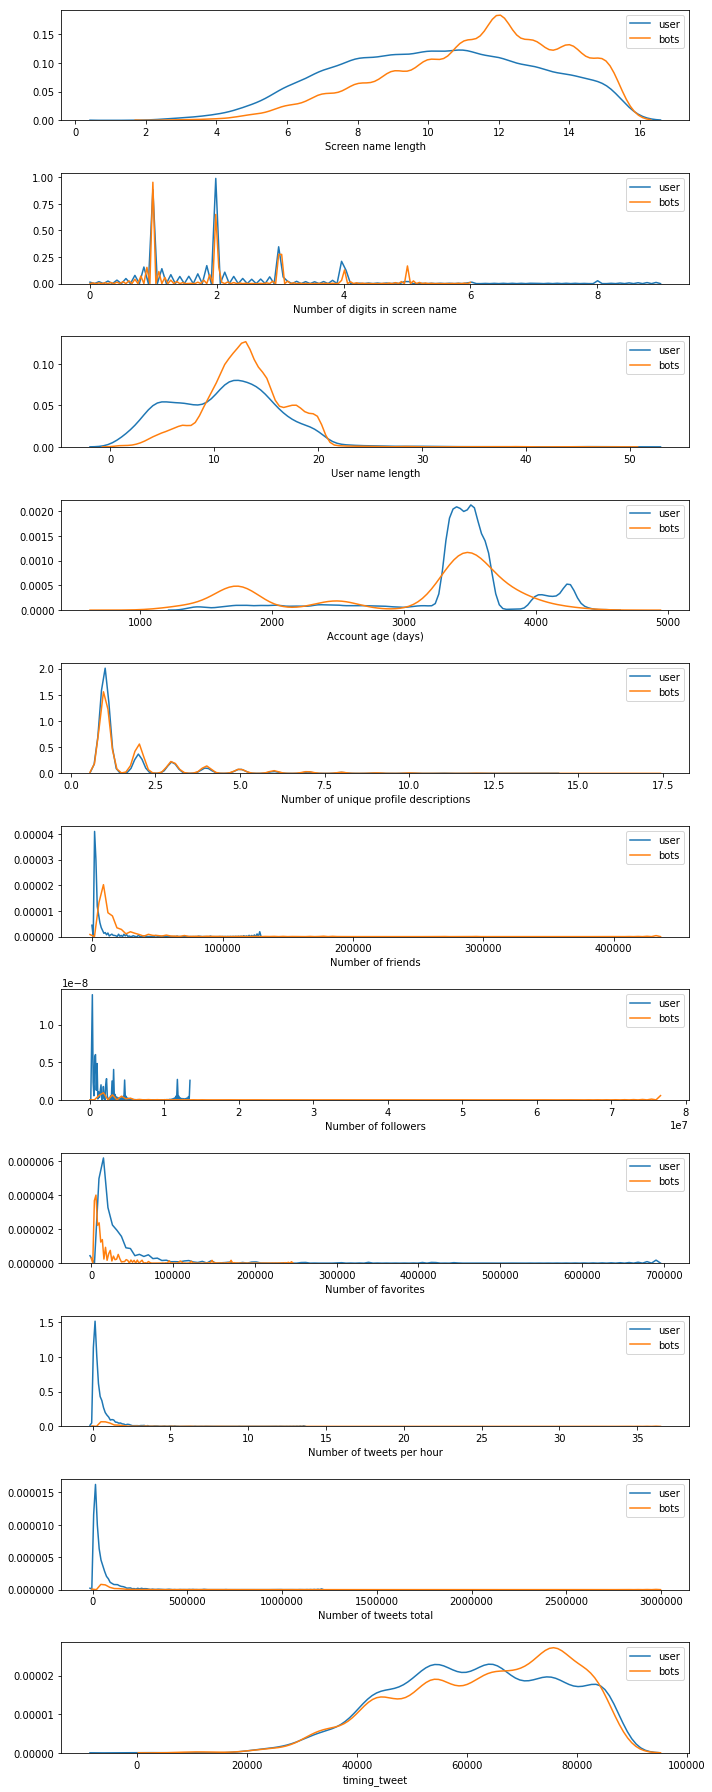

In [3]:
# Feature statistics
user_df_final = pd.read_csv('user_df_final.csv')
bot_df_final = pd.read_csv('bot_df_final.csv')
features = ['Screen name length', 'Number of digits in screen name', 'User name length', 'Account age (days)', 'Number of unique profile descriptions','Number of friends','Number of followers','Number of favorites','Number of tweets per hour', 'Number of tweets total','timing_tweet']
fig, axes = plt.subplots(len(features),1, figsize = (10,25))
for i in range(len(features)):
    sns.kdeplot(user_df_final[features[i]], ax = axes[i], label = 'user')
    sns.kdeplot(bot_df_final[features[i]], ax = axes[i], label = 'bots')
    axes[i].set_xlabel(features[i])
    axes[i].legend()

plt.tight_layout()
plt.savefig('kdeplot_features.png')
plt.show()

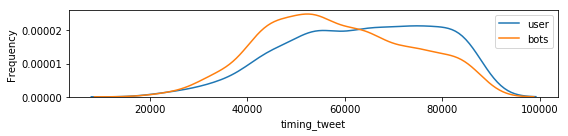

In [41]:
features = ['timing_tweet']
i = 0
fig = plt.gcf()
fig.set_size_inches(8,2)
sns.kdeplot(user_full_df[features[i]], label = 'user')
sns.kdeplot(bots_full_df[features[i]], label = 'bots')
    #axes[i].hist(user_full_df[features[i]], bins = 100, alpha = 0.5, density = True, label = 'user')
    #axes[i].hist(bots_full_df[features[i]], bins = 100, alpha = 0.5, density = True, label = 'bot')
    
plt.xlabel(features[i])
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.savefig('kdeplot_features2.png')
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


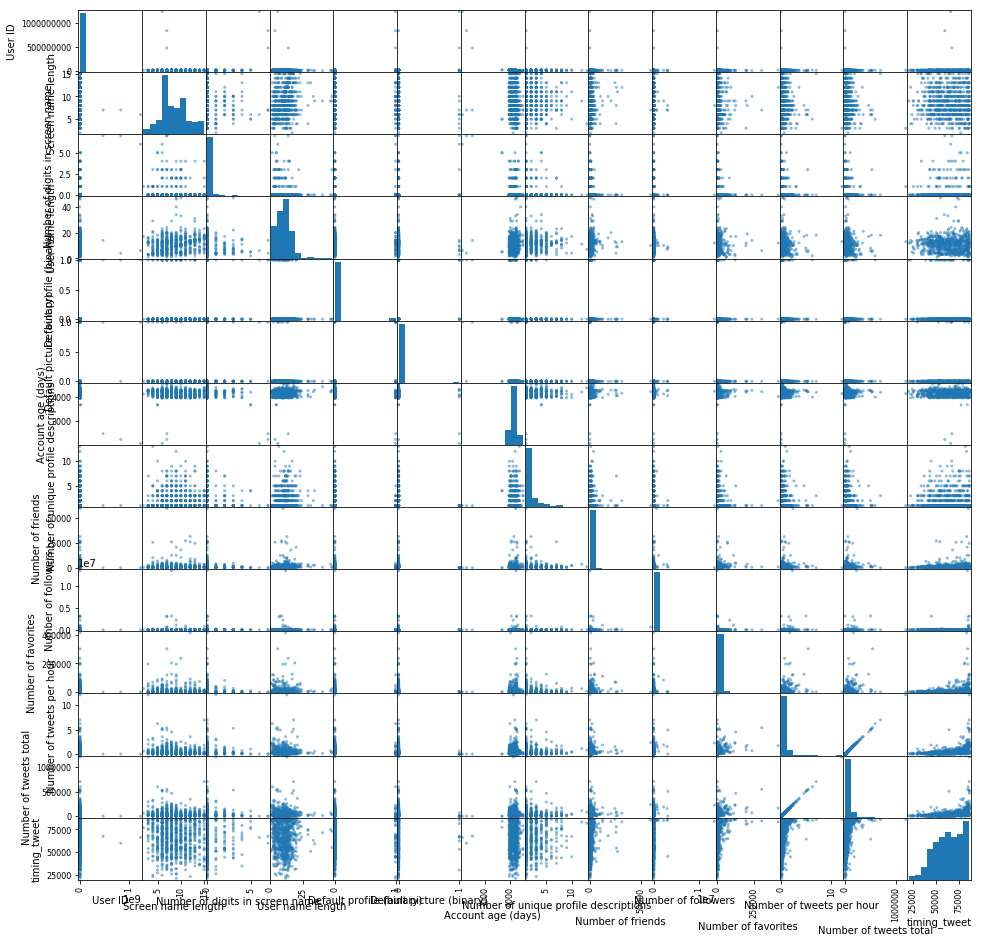

In [33]:
# Scatter matrix to see the correlation among extracted user and timing features
pd.scatter_matrix(user_full_df, figsize = (16,16))
plt.tight_layout()
plt.show()

In [6]:
bot_df = pd.read_csv('bot_df_final.csv')
user_df = pd.read_csv('user_df_final.csv')

In [31]:
fetched_tweets = api.search('trump', count = 10)

In [33]:
fetched_tweets[0].user.id

20118243

In [34]:
import io
import time

def get_tweets(query, count):

    # empty list to store parsed tweets
    tweets = []
    target = io.open("mytweets.txt", 'w', encoding='utf-8')
    # call twitter api to fetch tweets
    q=str(query)
    
    for i in range(12):
        fetched_tweets = api.search(q, count = count)
        # parsing tweets one by one
        print(len(fetched_tweets))
        #print(fetched_tweets)
    
        for tweet in fetched_tweets:

            # empty dictionary to store required params of a tweet
            parsed_tweet = {}
            # saving text of tweet
            #print(tweet.id)
            #parsed_tweet['UserID'] = tweet.id
            tweets.append(tweet.user.id)
            if "http" not in tweet.text:
                line = re.sub("[^A-Za-z]", " ", tweet.text)
                target.write(line+"\n")
                
        time.sleep(10)

    return tweets

    # creating object of TwitterClient Class
    # calling function to get tweets
tweets = get_tweets(query ="Trump", count = 100)

100
100
100
100
100
100
100
100
100
100
100
100


In [44]:
user_id_lst = list(set(tweets))
id_str_lst = [str(s) for s in user_id_lst]
start = time.time()
dfs_pred, fail_lst_pred = API_scrap(id_str_lst[0:1000], 10)
end = time.time()
print('Elapsed time:', end-start)
full_df_pred = create_df(dfs_pred, 'pred_dataframe')

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Elapsed time: 589.1669261455536


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in long_scalars


In [30]:
mashape_key = "uIX3UUkrh7mshux9VLXhN1FcUYY0p1ZEJpCjsnCHKddXFfIzhf"
twitter_app_auth = {
    'consumer_key': 'pr0AH7Ot5sZmig4u3bA6j51ty',
    'consumer_secret': 'tNteF0tRlEjKJfkkWQaIv5myqT9oBqrIVOYPQJOMjBTJhn9SAF',
    'access_token': '934846563825930241-yO5rosUB4x8eFMO0J7IXV1UZM0RzbgL',
    'access_token_secret': 'CbqfvlRonXo2JiIyxqCqeZynwkslNcDPmGFQ9KBEh8Mch',
  }
bom = botometer.Botometer(wait_on_ratelimit=True,
                          mashape_key=mashape_key,
                          **twitter_app_auth)

# Check a single account by screen name

result_lst = []
for user_id in user_id_lst[0:1000]:
    result = bom.check_account(user_id_lst[0])
    result.append(result)
    


# Check a single account by id
#result = bom.check_account(1548959833)

# Check a sequence of accounts
#accounts = ['@clayadavis', '@onurvarol', '@jabawack']
#for screen_name, result in bom.check_accounts_in(accounts):
    # Do stuff with `screen_name` and `result`

KeyboardInterrupt: 

In [47]:
start = time.time()
result = bom.check_account(user_id_lst[0])
end = time.time()
result

{'cap': {'english': 0.009922300094567935, 'universal': 0.007183846426565749},
 'categories': {'content': 0.4149558492738062,
  'friend': 0.20957193071779157,
  'network': 0.20385158449925947,
  'sentiment': 0.6700956285826207,
  'temporal': 0.2636844399869036,
  'user': 0.2533987749466703},
 'display_scores': {'content': 2.1,
  'english': 0.9,
  'friend': 1.0,
  'network': 1.0,
  'sentiment': 3.4,
  'temporal': 1.3,
  'universal': 0.7,
  'user': 1.3},
 'scores': {'english': 0.1807672693005155, 'universal': 0.13802618960216584},
 'user': {'id_str': '876476261220179968', 'screen_name': 'CKassube'}}

In [48]:
end-start

3.081282138824463

In [43]:
id_str_lst = [str(s) for s in user_id_lst]